<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">
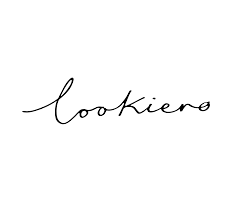    


---
<h3>Beñat Basabe, Jon Jarrín, June Pagaldai, Daniel Puente, Eneko Rentería | <font color='red'> Equipo Rojo<h3>

## Análisis inicial
En este script se detallarán los descriptivos obtenidos de este primer análisis. Tareas como detectar **cantidad de valores missing** o **outliers** entre otros.

### Carga de librerias 
---

- **General**

In [1]:
import pandas as pd
import numpy as np
import glob
import os
from IPython.display import clear_output

* **Gráficos**

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

* **Grafos**

In [2]:
import networkx as nx

- **Pyspark**

In [3]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkFiles
from pyspark.sql import functions as F
import pyspark.sql.functions as f
from pyspark.sql.functions import lit, trim, split, regexp_replace, when

- **Strings**

In [4]:
from collections import Counter
import re

* **Otros**

In [ ]:
import itertools

### Clases a utilizar
---

* Clase para **cargar de datos** (cd)

Se fijan los **directorios** de entrada y salida

In [5]:
dir_in, dir_out = "../../datos/datos_originales/", "../../datos/datos_desarrollo/"

spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

In [6]:
class carga_datos:
    ''' Cargar los datos desde el csv al python:
    - subir_tablas: se suben los dataframes con los titulos deseados. Como input: una lista de dfs y una lista de titulos.
    - subir_una_tabla: como input se especifica la tabla a subir.
    '''
    def __init__(self, dir_in = dir_in):
        self.dir_in = dir_in
        
    def subir_tablas(self, dir_in):
        try: 
            path = os.getcwd()
            csv_files, dataframes_list = glob.glob(os.path.join(path, dir_in + "*.csv")), []
            for i in csv_files:
                temp_df = spark.read.csv(path = i, header = True, inferSchema = True)
                dataframes_list.append(temp_df)
  
        except: pass
            
        return dataframes_list
    def subir_una_tabla(self, dir_in, nombre_tabla):
        return pd.read_csv(os.path.join(dir_in, nombre_tabla + ".csv"))

In [7]:
cd = carga_datos ()

## Funciones a utilizar
---

- Función para **dar nombre** a la variable **family_id** mediante la variable title

In [8]:
def get_family_name(id_):
    
    filtered = product.filter(product.family_id == id_)
    string = ' '.join([x['title'] for x in filtered.select('title').collect()]).lower()
    
    return id_, Counter(string.split()).most_common(1)[0][0]

- Función para crear los **sufijos** y facilitar el *join*

In [9]:
def rename_columns(df, suffix):
    ''' Renombra las columnas de un dataframe.'''
    for names in df.schema.names: df = df.withColumnRenamed(names,names + suffix)
    return df

def get_value(dffs, variable):
    valores = [x[0] for x in dffs.select(variable).distinct().collect()]
    return valores

---

In [10]:
dfs = cd.subir_tablas(dir_in)
titulos = os.listdir(dir_in)

### Adecuar el *dataframe* size

In [11]:
size = cd.subir_una_tabla(dir_in, 'size')
size.to_csv(dir_out + 'size2.csv', sep = ';')
dfs[-1] = spark.read.csv(path = dir_out + 'size2.csv', header = True, inferSchema = True, sep = ';')

### Unión de *dataframes*

<center> 
<img  src="../imagenes/diagrama.PNG"> 

#### 1) df_total =  product variant + color + size + season

- **Season**: No utilizar
- **Size**: Utilizar solo la talla creada por *lookiero*
- **Color**: Utilizar solo el nombre del color

product_variant + size = 116 not used sizes NAN  
product_variant_size + color = 1 not used color (mixt) NAN

* Renombrar con sufijos para facilitar el *join*

In [12]:
dfs[-1] = rename_columns(dfs[-1], '_size')
dfs[1] = rename_columns(dfs[1], '_color')

* Se junta los 2 dataframes en uno solo.

In [13]:
df_total = dfs[10].join(dfs[-1].select('id_size','lookiero_size'), dfs[10].size_id == dfs[-1].id_size, "inner").drop('id_size', 'size_id')
df_total = df_total.join(dfs[1].select('id_color', 'name_color'), df_total.color_id == dfs[1].id_color).drop('id_color', 'color_id', 'legacy_id', 'barcode')
df_total = df_total.withColumn("publishable", when(df_total.publishable == "f",False).when(df_total.publishable == "t",True))
df_total = df_total.withColumnRenamed("lookiero_size","size_lookiero") \
    .withColumnRenamed("name_color","color")

* Se modifica la variable size_lookiero para que tenga formato legible

In [14]:
df_total = df_total.withColumn('size_lookiero', split(df_total['size_lookiero'], ':').getItem(1))
df_total = df_total.withColumn('size_lookiero', regexp_replace('size_lookiero', '""', ''))
df_total = df_total.withColumn('size_lookiero', split(df_total['size_lookiero'], ',').getItem(0))
df_total = df_total.withColumn('size_lookiero', trim(f.col("size_lookiero")))

#### 2) df_total += product

product_variant + product = 41291 (63'3%) with no product_family or brand NAN

- **Product**: Dar nombre a la variable family_id y eliminar *legacy_id* y *channels*

* Crear las parejas

In [15]:
product = dfs[7].drop('legacy_id', 'channels')

unique_values_family =  [x['family_id'] for x in product.select('family_id').distinct().collect()]
parejas = dict(map(get_family_name, unique_values_family))
product = product.withColumn("product_family", product["family_id"])

* Mapear las parejas creadas

In [16]:
for k, v in enumerate(unique_values_family): 
    product = product.withColumn('product_family', regexp_replace('product_family', v, str(parejas[v])))

* Renombra la columna a la hora de unir

In [17]:
product = product.drop('family_id', 'title', '"""group"""')
product = rename_columns(product, '_product')

df_total = df_total.join(product, df_total.product_id == product.id_product).drop('product_id')
df_total = df_total.withColumnRenamed("product_family_product","family_product")

#### 3) df_total += brand

- **brand**: No utilizar variable number

df_total + brand = 0 NAN

In [18]:
brand = dfs[0].drop('number')
brand = brand.withColumnRenamed("id","id").withColumnRenamed("name","brand").withColumnRenamed("origin","brand_origin")
brand = rename_columns(brand, '_brand')
df_total = df_total.join(brand, df_total.brand_id_product == brand.id_brand).drop('brand_id_product','brand_id', 'id_brand')
df_total = df_total.withColumnRenamed("brand_brand", "name_brand").withColumnRenamed("brand_origin_brand", "origin_brand")

#### 4) values = feature values + feature (*value caracteristics*)

- **feature**: Multiple convertir en booleano (borrar??) y para poder eliminar la variable unit pasar los porcentajes a decimales (para diferenciarlos)

feature + feature_value = 1 value caracteristic not used NAN

In [19]:
feature = dfs[3]
feature = feature.withColumn("multiple", when(feature.multiple == "f",False).when(feature.multiple == "t",True))
column_names = ['id', 'feature_name', 'feature_type', 'feature_multiple', 'unit']

for k, v in enumerate(column_names):  feature = feature.withColumnRenamed(feature.schema.names[k], v)
feature_value = dfs[5]
feature = rename_columns(feature, '_values')
values = feature_value.join(feature, feature_value.feature_id == feature.id_values).drop('feature_id','id_values', 'feature_type_values', 'unit_values')

### **Hay que corregirlo pero no sé cómo**	

feature_family no sirve para nada **creo** por lo que las siguientes celda en raw

#### 5) values + value family

In [20]:
for k, v in enumerate(['feature_family', 'feature_value_id']):  dfs[6] = dfs[6].withColumnRenamed(dfs[6].schema.names[k], v)
values = values.join(dfs[6], values.id == dfs[6].feature_value_id).drop('feature_value_id')

#### 6) product_values = values + product_feature_value

values + product_feature_value = 1420 (1'84%) caracteristics that has no product NAN

In [21]:
values = values.withColumnRenamed('id', 'id_values')
dfs[8] = dfs[8].withColumnRenamed('id', 'id_product_feature')
product_values = values.join(dfs[8], values.id_values == dfs[8].feature_value_id).drop('feature_value_id')

#### 7) product_values + df_total

products + features = 383 (0'06%) products without caracteristics NAN

In [22]:
df = df_total.join(product_values, df_total.id_product == product_values.product_id).drop('product_id')

* Adecuar variables para la comprensión

In [23]:
df = df.drop('id_values', 'multiple_values') # id_product_feature
df = df.withColumnRenamed('feature_multiple_values', 'multiple_values').withColumnRenamed('feature_name_values','name_feature')
df = df.withColumn('id_product', f.concat(f.col('family_product'), lit('_'), f.col('color') , lit('_'), f.col('size_lookiero'), lit('_'), f.col('season')))
df = df.withColumn('id_product_feature', f.concat(f.col('name_feature'), lit('_'), f.col('value')))

- id = Un único producto (se repite pork tiene diferentes features)  
- id_product = El producto en general (niki manga larga)  
- id_values = id de una característica (**borrado**)     
- id_product_feature = id de la característica de un producto en general (id_product)(**borrado**)

In [31]:
print((df.count(), len(df.columns)))
df.show()

(14285646, 15)
+--------------------+------+-----+-----------+-------------+---------+--------------------+--------------+----------+-------------+-----+------------+---------------+--------------------+------------------+
|                  id|season|stock|publishable|size_lookiero|    color|          id_product|family_product|name_brand| origin_brand|value|name_feature|multiple_values|      feature_family|id_product_feature|
+--------------------+------+-----+-----------+-------------+---------+--------------------+--------------+----------+-------------+-----+------------+---------------+--------------------+------------------+
|498662e5-11e8-483...|     8|    0|       true|            M|     ecru|   cardigan_ecru_M_8|      cardigan|  BRAND112|NO_MAINSTREAM|   55| hip_contour|          false|c6b81db8-29ed-43d...|    hip_contour_55|
|dcda2fe4-58e3-4b2...|     8|    0|       true|            S|     ecru|   cardigan_ecru_S_8|      cardigan|  BRAND112|NO_MAINSTREAM|   55| hip_contour|  

* **Missing values** (tarda bastante en ejecutar)

* **Some group by**

In [56]:
from pyspark.sql.functions import isnan, when, count, col, countDistinct
df.groupBy("family_product").agg(countDistinct("name_feature")).show()

+--------------+-------------------+
|family_product|count(name_feature)|
+--------------+-------------------+
|           3.1|                 32|
|           2.2|                 31|
|           3.2|                 14|
|           1.1|                 36|
|           2.1|                 32|
|           1.2|                 27|
+--------------+-------------------+



### Guardar - Todavía en proceso
---

### Relaciones
---

* Crear variables para verificar reglas

In [24]:
niveles = {'jumpsuit': '1.1', 
           'dress': '1.1',
           
           'jeans': '1.2',
           'skirt': '1.2',
           'short': '1.2',
           'pant': '1.2',
          
           'shirt': '2.1',
           'top': '2.1',
           'tshirt': '2.1',
          
           'sweater': '2.2',
           'sweatshirt': '2.2',
           'cardigan': '2.2',
          
           'trench': '3.1',
           'coat': '3.1',
           'parka': '3.1',
           'jacket': '3.1',
          
           'bag': '3.2',
           'scarf': '3.2'}

df = df.withColumn('level', df['family_product'])
df = df.replace(niveles, 'level')

C:\Users\Daniel\anaconda3\envs\reto10_rojo\lib\site-packages\pyspark\sql\dataframe.py:2233: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


**COMBINACIONES NO POSIBLES:**
- 1.2 + 3.2 + 3.2 (*falta parte de arriba*)
- 2.1 + 2.1 (*demasiados nikis*)
- 2.2 + 2.2 (*demasiados jerses*)
- 3.1 + 3.1 (*demasiadas txammaras*)

* Ponderaciones de relaciones

### Grafo
---

#### 1) Nodos *(está solo con 10)*

- Crear el grafo y los productos 

In [29]:
G = nx.Graph()
vu_id_product, vu_id, vu_level = get_value(df, 'id_product'), get_value(df, 'id'), get_value(df, 'level')

* Añadir los productos con su color y size en el grafo

In [30]:
for k, v in enumerate(vu_id_product[:50]):
    G.add_node(k, color = get_value(df.filter(df.id_product == v), 'color')[0], size = get_value(df.filter(df.id_product == v), 'size_lookiero')[0], level = get_value(df.filter(df.id_product == v), 'level')[0][0], season = get_value(df.filter(df.id_product == v), 'season')[0])

* Relación de número (id) con producto

In [31]:
df_para_filtrar = pd.DataFrame(vu_id_product).reset_index()
df_para_filtrar['family_product'] = pd.Series([e[0] for e in df_para_filtrar[0].str.split('_')])
df_para_filtrar['level'] = df_para_filtrar.family_product.map(niveles)

#### 2) Aristas

Filtramos el df para que no tarde tanto

In [ ]:
filtrado = df.filter(df.id_product.isin(vu_id_product[:50]))

**Aristas: Temporada** (*está para 10 combinaciones*)

In [32]:
combinaciones_temporada = []

for i in [7,8,9]:
    
    filtrado_2 = filtrado.filter(filtrado.season == i).select('id_product')
    valores = get_value(filtrado_2, 'id_product')
    indeces_estaciones = df_para_filtrar[df_para_filtrar[0].isin(valores)].index.tolist()
    combinaciones = list(itertools.combinations(indeces_estaciones, 2))
    combinaciones_temporada += combinaciones

**Aristas: Level** (*está para todas las combinaciones*)

- Crear combinaciones (aristas)

In [33]:
levels = get_value(df.filter(df.id_product.isin(vu_id_product)), 'level')
levels.sort()
tods = list(itertools.combinations(levels, 3))
tods.sort()

* Cambios necesarios para que cumplan las reglas definidas

In [34]:
tods = [v for x, v in enumerate(tods) if x not in [0,1,2,3]]
tods += [('1.1', '3.2', '3.2')]
tods = [x for x in tods if x[0][0][0] == '1']

* Traducir de combinaciones de *levels* a los ids de los nodos

In [35]:
df_para_filtrar.columns = ['index', 'id_product', 'family_product', 'level']

* Se generan las combinaciones del *level* y se genera un **graphlet G2** (triangulo), para generar las relaciones

In [36]:
for e in tods:

    list_1 = df_para_filtrar[df_para_filtrar.level == e[0]].index.to_list()
    list_2 = df_para_filtrar[df_para_filtrar.level == e[1]].index.to_list()
    list_3 = df_para_filtrar[df_para_filtrar.level == e[2]].index.to_list()
    
    if len(list_1) > 0 and len(list_2) > 0 and len(list_3) > 0:
        combinaciones_level = list(itertools.product(list_1, list_2, list_3))
        for c in combinaciones_level:
            K_3 = nx.complete_graph((c))
            G.add_edges_from(K_3.edges)
ejes_actuales = list(G.edges())

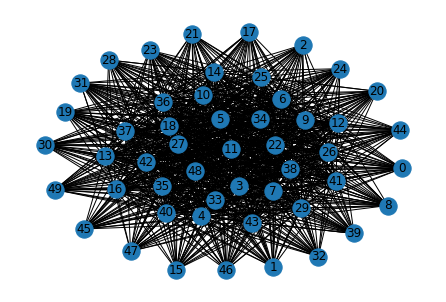

In [37]:
nx.draw(G, with_labels = True)

**Aristas: Tallas**

* Se consigue las tallas

In [38]:
df_para_filtrar['talla'] = df_para_filtrar['id_product'].apply(lambda x:x.split('_')[-2])
orden_tallas = ['XXS', 'XS', 'S', 'M', 'L', 'XL', 'XXL', 'XXXL','X4XL']

* Se establece que sólo puede haber 1 talla de diferencia

In [39]:
combinaciones_tallas = []
try:
    for x, v in enumerate(orden_tallas): combinaciones_tallas += [(v,orden_tallas[x+1])]
except:pass

* Se genera las combinaciones de tallas y luego los valores propios ya que hay valores repetidos

In [40]:
combinaciones_tallas_nodos = []
for x in combinaciones_tallas:
    list_1 = df_para_filtrar[df_para_filtrar.talla.isin(x)].index.to_list()
    combinaciones_tallas_nodos += list(itertools.combinations(list_1, 2))

combinaciones_tallas_nodos = list(set(combinaciones_tallas_nodos))

**Aristas: Completo**

* En caso de que solo tenga que cumplir 1:

In [41]:
aristas_sin_level = list(set(combinaciones_temporada + combinaciones_tallas_nodos))

* En caso de que tenga que cumplir todos:

In [42]:
aristas_sin_level = list(set(set(combinaciones_temporada).intersection(combinaciones_tallas_nodos)))
print(aristas_sin_level)

[(15, 21), (33, 36), (43, 46), (42, 48), (44, 45), (35, 42), (7, 35), (22, 26), (0, 5), (31, 47), (12, 43), (0, 23), (3, 40), (5, 37), (1, 15), (14, 49), (1, 24), (32, 39), (8, 39), (25, 34), (12, 27), (3, 33), (5, 30), (20, 49), (3, 42), (1, 8), (15, 16), (15, 25), (2, 25), (8, 41), (0, 37), (2, 34), (12, 20), (29, 36), (38, 39), (5, 23), (3, 35), (14, 44), (8, 25), (8, 34), (0, 30), (16, 26), (11, 48), (21, 25), (38, 41), (21, 34), (9, 14), (14, 28), (20, 44), (12, 49), (45, 46), (1, 21), (33, 35), (27, 49), (9, 44), (1, 39), (20, 28), (39, 41), (29, 40), (6, 47), (34, 39), (4, 47), (37, 44), (16, 21), (8, 38), (9, 37), (19, 47), (9, 46), (32, 41), (6, 22), (15, 34), (6, 31), (29, 42), (40, 42), (4, 22), (4, 31), (2, 6), (19, 22), (34, 41), (1, 16), (2, 15), (19, 31), (7, 11), (1, 25), (37, 46), (28, 43), (25, 26), (11, 36), (6, 15), (3, 7), (4, 6), (24, 39), (29, 35), (12, 28), (23, 37), (8, 15), (27, 28), (2, 8), (8, 24), (36, 40), (14, 46), (2, 26), (11, 29), (24, 32), (43, 45), (

* Se añaden los edges que ya están en el gráfo (*level* con graphlet G2) y los generados previamente. Se realiza la intersección

In [43]:
lista_final = list(set( set(list(G.edges())).intersection(aristas_sin_level)   ))

* Se eliminan las relaciones anteriormente creadas
* Se añaden las nuevas relaciones

In [44]:
G.remove_edges_from(list(G.edges()))
G.add_edges_from(lista_final)

* **3-node graphlets G2**

In [47]:
target, a_3 = nx.complete_graph(3), []
for sub_nodes in itertools.combinations(G.nodes(),len(target.nodes())):
    subg = G.subgraph(sub_nodes)
    if nx.is_connected(subg): a_3.append(list(subg.edges()))

G2_graphlet = [x for x in a_3 if len(x) == 3]
print(len(G2_graphlet))

(84, 119)

#### 3) Ponderaciones

##### **Marcas**

* Generar pesos (% de marcas iguales entre nodos relacionados **(tienen que pertenecer al mismo graphlet)**)

In [127]:
pesos, count = [], 1

for x in G2_graphlet:
    for i in x:
        producto_1, producto_2 = df_para_filtrar.iloc[i[0],:]['id_product'], df_para_filtrar.iloc[i[1],:]['id_product']

        marcas_1, marcas_2 = filtrado.filter(filtrado.id_product == producto_1).select('name_brand').distinct(), filtrado.filter(filtrado.id_product == producto_2).select('name_brand').distinct()
        marcas_1, marcas_2 = get_value(marcas_1, 'name_brand'), get_value(marcas_2, 'name_brand')


        if len(set(marcas_1).intersection(set(marcas_2))) != 0:  weigth = len( set(marcas_1).intersection(set(marcas_2)) ) / max( len(marcas_1), len(marcas_2))
        else: weigth = 0
        pesos.append([ i[0], i[1],  weigth ])
    print(count, '/', len(G2_graphlet))
    count += 1
    clear_output(wait=True)

37 / 37


* Se añaden los pesos de las aristas del grafo

In [141]:
for x in pesos: G[x[0]][x[1]]['weight'] = x[2]

* Se seleecionan los looks que tienen un peso mayor. Para ello se hace la suma de los edges del graphlet. Posteriormente se ordenan de manera descendente


In [153]:
def añadir_pesos(G2_graphlet):
    for k, v in enumerate(G2_graphlet): 
        peso_1 = G.get_edge_data(v[0][0], v[0][1])['weight']
        peso_2 = G.get_edge_data(v[1][0], v[1][1])['weight']
        peso_3 = G.get_edge_data(v[2][0], v[2][1])['weight']

        G2_graphlet[k].append(peso_1 + peso_2 + peso_3)
        
    return G2_graphlet

G2_graphlet_pesos = añadir_pesos(G2_graphlet)
G2_graphlet_pesos =  np.array(G2_graphlet_pesos)
G2_graphlet_pesos = G2_graphlet_pesos[G2_graphlet_pesos[:,3].argsort()][::-1]

* Se consiguen los looks con **mayor peso**

In [182]:
looks = [ [ df_para_filtrar.loc[x[0][0],'id_product'], df_para_filtrar.loc[x[0][1],'id_product'], df_para_filtrar.loc[x[1][1],'id_product']  ] for x in G2_graphlet_pesos[:15]]

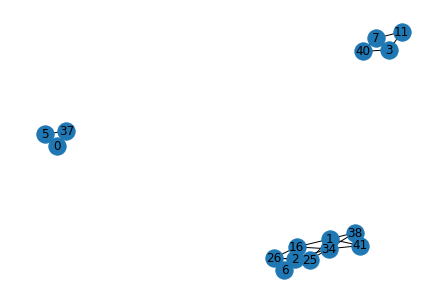

In [49]:
H = nx.Graph()
for x in G2_graphlet_pesos[:15]: 
    H.add_edges_from(x)
nx.draw(H, with_labels = True)

### Gráficos
---

In [59]:
def human_format(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '%.2f%s' % (num, ['', 'K', 'M', 'B', 'T', 'P'][magnitude])

paleta=['#264653','#2A9D8F','#85CAC2','#DFF6F4' ,'#E9C46A','#F4A261','#E76F51','#C53D1B', '#7E2711']

#### Estaciones

In [60]:
season_collection = dfs[-3].select('season').collect()
season = np.array([x[0] for x in season_collection])
count_values = np.bincount(season)[-3:]

fig = go.Figure(data=[go.Bar( x=count_values, y=['7', '8', '9'],text=count_values,textposition='auto',texttemplate = [human_format(a) for a in count_values],orientation='h')])
fig.update_traces(marker_color=[paleta[0], paleta[1], paleta[0]],marker_line_width=1, opacity=0.8, marker_line_color = 'black')

fig.update_layout(
    title='Estaciones más frecuente Lookiero',
    xaxis_title = 'Cantidad',
    yaxis_title = 'Estaciones', 
    # width=2280, height=950, font = dict(size = 22),
    paper_bgcolor='white',
    plot_bgcolor='white', 
    xaxis_range=[20000,23000]
)

#### Familias de producto

In [62]:
product_family = df_total.select('family_product').collect()
product_family = np.array([x[0] for x in product_family])
unique_elements, counts_elements = np.unique(product_family, return_counts=True)
counts_elements, unique_elements = (zip(*reversed(sorted(zip(counts_elements, unique_elements)))))

In [63]:
colores = [paleta[1]] * 3 + [paleta[0]] * (len(counts_elements) - 9) + [paleta[6]] * 6
fig = go.Figure(data=[go.Bar( x=unique_elements, y=counts_elements,text=count_values,textposition='auto',texttemplate = [human_format(a) for a in counts_elements], orientation='v')])
fig.update_traces(marker_color=colores,marker_line_width=1, opacity=0.8, marker_line_color = 'black')

fig.update_layout(
    title='Productos más populares',
    xaxis_title = 'Productos',
    yaxis_title = 'Cantidad',
    # width=2280, height=950, font = dict(size = 22),
    paper_bgcolor='white',
    plot_bgcolor='white')


#### Size percentaje

In [64]:
size_lookiero = df_total.select('size_lookiero').collect()
size_lookiero = np.array([x[0] for x in size_lookiero])

unique_elements, counts_elements = np.unique(size_lookiero, return_counts=True)
counts_elements, unique_elements = (zip(*reversed(sorted(zip(counts_elements, unique_elements)))))
counts_elements, unique_elements = np.array(counts_elements), np.array(unique_elements)
counts_elements = (counts_elements / counts_elements.sum()) * 100

In [65]:
labels = unique_elements


fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=counts_elements, name="GHG Emissions", marker_colors = paleta),1, 1)


fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Cantidad de productos por tamaño",
    # width=2280, height=950, 
    font = dict(size = 22),
    annotations=[dict(text='Tallas', x=0.20, y=0.5, 
    font_size=16, showarrow=False
    )])
fig.show()

#### Tallas - Productos


In [66]:
tallas = df_total.select('size_lookiero').collect()
tallas = np.array([x[0] for x in tallas])
df_heat = pd.DataFrame()
df_heat['size'], df_heat['product_family'] = tallas, product_family

hm_131_p = pd.get_dummies(df_heat, columns=['product_family']).groupby(['size']).sum()
hm_131_p.columns = [x.replace('product_family_', '').capitalize() for x in hm_131_p.columns]

Text(0.5, 1.0, 'Relación entre tallas y productos')

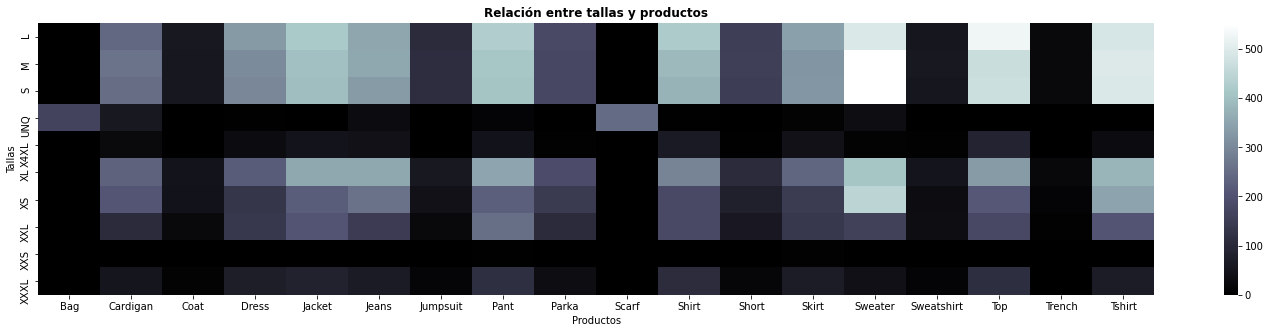

In [67]:
fig3, ax3 = plt.subplots(figsize = (25,5))
ax3 = sns.heatmap(hm_131_p,cmap='bone')
ax3.set_ylabel('Tallas')
ax3.set_xlabel('Productos')
ax3.set_title("Relación entre tallas y productos",fontweight='bold')

#### Empresas con mayor stock

In [69]:
empresas = df_total.select('name_brand').collect()
empresas = np.array([x[0] for x in empresas])
stock = np.array([x[0] for x in df_total.select('stock').collect()])

In [70]:
df_empresas_stock = pd.DataFrame()
df_empresas_stock['empresas'], df_empresas_stock['stock'] = empresas, stock
top_10_empresas = df_empresas_stock.groupby('empresas').agg({'stock':'sum'}).sort_values(by='stock', ascending=False).head(10).reset_index()
valores = df_empresas_stock.groupby('empresas').agg({'stock':'sum'}).sort_values(by='stock', ascending=False).head(10)
errors = df_empresas_stock.groupby('empresas').agg({'stock':'std'}).sort_values(by='stock', ascending=False).head(10)

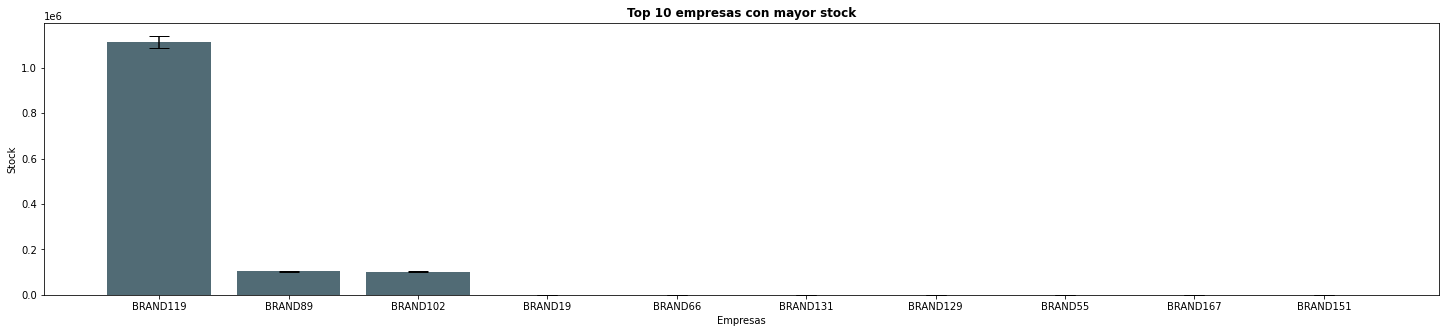

In [71]:
fig, ax = plt.subplots(figsize = (25,5))

ax.bar(valores.index, valores.stock, yerr=errors.stock, align='center', alpha=0.8, ecolor='black', capsize=10, color = paleta[0])
ax.set_facecolor('white')
plt.title('Top 10 empresas con mayor stock', fontweight='bold')
plt.xlabel('Empresas')
plt.ylabel('Stock')
plt.show()

Viendo que muchas empresas no se puede ver el stock que tiene, se decide generar otro gráfico para ver más en detalle el stock de esas empresas.

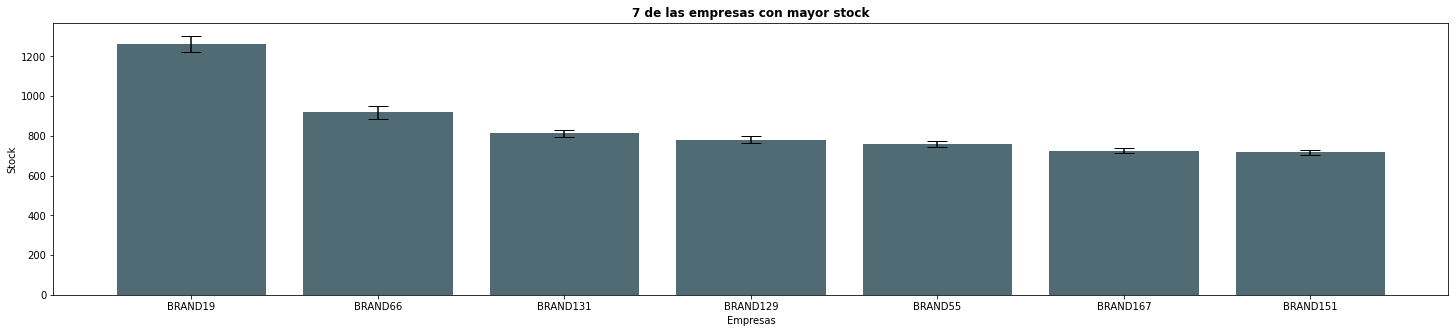

In [72]:
fig, ax = plt.subplots(figsize = (25,5))

ax.bar(valores.index[3:], valores.stock[3:], yerr=errors.stock[3:], align='center', alpha=0.8, ecolor='black', capsize=10, color = paleta[0])
ax.set_facecolor('white')
plt.title('7 de las empresas con mayor stock', fontweight='bold')
plt.xlabel('Empresas')
plt.ylabel('Stock')
plt.show()

#### Productos más vendidos y origin

In [73]:
product_family = df_total.select('family_product').collect()
product_family = np.array([x[0] for x in product_family])
unique_elements, counts_elements = np.unique(product_family, return_counts=True)
counts_elements, unique_elements = (zip(*reversed(sorted(zip(counts_elements, unique_elements)))))

In [74]:
product_family_product, brand_origin_brand = np.array([x[0] for x in df_total.select('family_product').collect()]), np.array([x[0] for x in df_total.select('origin_brand').collect()])
df_product_family_product = pd.DataFrame()
df_product_family_product['product_family_product'], df_product_family_product['brand_origin_brand'] = product_family_product, brand_origin_brand
df_product_family_product = df_product_family_product[df_product_family_product['product_family_product'].isin(unique_elements[:5])].reset_index(drop = True)

In [75]:
dumificado = pd.get_dummies(df_product_family_product, columns=['product_family_product']).groupby(['brand_origin_brand']).sum().reset_index()
dumificado.columns = [dumificado.columns[0]] + [x.replace('product_family_product_', '').capitalize() for x in dumificado.columns[1:]]
for x in range(len(dumificado)): 
    dumificado.iloc[x, 1:] = (dumificado.iloc[x, 1:] / dumificado.iloc[x, 1:].sum() * 100)
    dumificado.iloc[x, 1:] = dumificado.iloc[x,1:].apply(lambda x: x.round(1))

In [76]:
from itertools import cycle

x_data = dumificado.iloc[:, 1:].values

import plotly.graph_objects as go


top_labels = dumificado.columns[1:]
colors = np.array(paleta)[[0,1,2,4,5]]
y_data = dumificado.iloc[:,0].values

fig = go.Figure()

for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],orientation='h',marker=dict(color=colors[i],line=dict(color='rgb(248, 248, 249)', width=1))))

fig.update_layout(
    title='Productos más populares y su influencia en el mercado',
    xaxis=dict(
        showgrid=False,showline=False,showticklabels=False,zeroline=False,domain=[0.15, 1]),

    yaxis=dict(
        showgrid=False,showline=False,showticklabels=False,zeroline=False,),
    width=2280, height=850, font = dict(size = 22),
    barmode='stack',paper_bgcolor='white',plot_bgcolor='white',margin=dict(l=120, r=10, t=140, b=80),showlegend=False,)

annotations = []

for yd, xd in zip(y_data, x_data):

    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,xanchor='right',text=str(yd),font=dict(family='Arial', size=22,color='rgb(67, 67, 67)'),showarrow=False, align='right'))

    annotations.append(dict(xref='x', yref='y',
                            x=xd[0] / 2, y=yd,text=str(xd[0]) + '%',font=dict(family='Arial', size=22,color='rgb(248, 248, 255)'),showarrow=False))

    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,text=top_labels[0],font=dict(family='Arial', size=22,color='rgb(67, 67, 67)'),showarrow=False))
                                
    space = xd[0]
    for i in range(1, len(xd)):
            annotations.append(dict(xref='x', yref='y',
                                    x=space + (xd[i]/2), y=yd,text=str(xd[i]) + '%',font=dict(family='Arial', size=22,color='rgb(248, 248, 255)'),showarrow=False))
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,text=top_labels[i],font=dict(family='Arial', size=22,color='rgb(67, 67, 67)'),showarrow=False)) #, textangle=90
            space += xd[i]

fig.update_layout(annotations=annotations)
fig.show()

#### Puntos

In [77]:
product_family = np.array([x[0] for x in df_total.select('family_product').collect()])
unique_elements, counts_elements = np.unique(product_family, return_counts=True)
counts_elements, unique_elements = (zip(*reversed(sorted(zip(counts_elements, unique_elements)))))

color, product_family_product = np.array([x[0] for x in df_total.select('color').collect()]), np.array([x[0] for x in df_total.select('family_product').collect()])
df_color = pd.DataFrame()
df_color['color'], df_color['product_family_product'] = color, product_family_product

dumificado = pd.get_dummies(df_color, columns=['product_family_product']).groupby(['color']).sum().reset_index()
dumificado.columns = [dumificado.columns[0]] + [x.replace('product_family_product_', '') for x in dumificado.columns[1:]]
dumificado['total'] = dumificado.iloc[:,1:].sum(axis=1)

dumificado = dumificado.loc[:,['color','total'] + list(unique_elements[:3])]

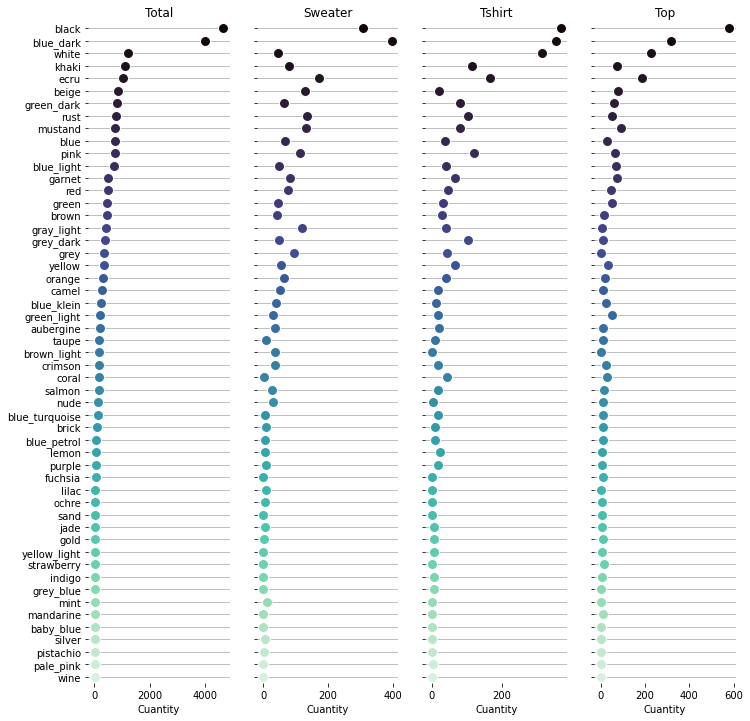

In [78]:
g = sns.PairGrid(dumificado.sort_values("total", ascending=False),
                 x_vars=dumificado.columns[-4:], y_vars=["color"],
                 height=10, aspect=.25)

g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="mako", linewidth=1, edgecolor="w")

g.set(xlabel="Cuantity", ylabel="")
titles = [x.capitalize() for x in dumificado.columns[-4:]]

for ax, title in zip(g.axes.flat, titles):
    ax.set(title=title)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

#### Spider (Sin acabar)

In [80]:
publishable = np.array([x[0] for x in df_total.select('publishable').collect()])
stock = np.array([x[0] for x in df_total.select('stock').collect()])

df_empresas_spider = pd.DataFrame()
df_empresas_spider['publishable'], df_empresas_spider['stock'], df_empresas_spider['brand_origin_brand'] = publishable, stock, brand_origin_brand
df_empresas_spider = df_empresas_spider.pivot_table(index = 'publishable', columns='brand_origin_brand', values = 'stock', aggfunc ='sum')
df_empresas_spider.reset_index(drop = True, inplace = True)

df_empresas_spider = ((df_empresas_spider.T / df_empresas_spider.sum(axis = 1))*100).T
df_empresas_spider = pd.concat([pd.Series(['No Published', 'Published']), df_empresas_spider], axis = 1).rename({0: 'group'}, axis = 1)

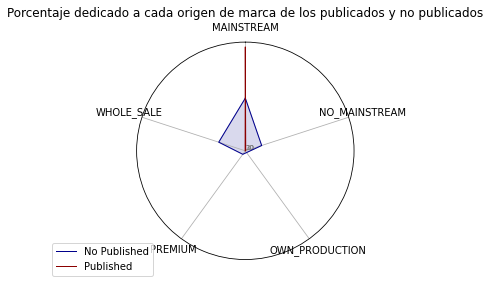

In [81]:
from math import pi

df_empresas_spider['group'] = df_empresas_spider['group'].astype('str')
categories = list(df_empresas_spider)[1:]
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], categories)
ax.set_rlabel_position(0)
plt.yticks([0.12,0.2,0.28], ["10","20","30"], color="grey", size=7)

 
color_list = ['darkblue', 'darkred', 'darkgreen']

for i in range(len(df_empresas_spider)):
    
    values = df_empresas_spider.loc[i].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth = 1, linestyle='solid', label = df_empresas_spider.group[i], color = color_list[i])
    ax.fill(angles, values, color = color_list[i], alpha = 0.15)
    
plt.legend(loc = 'upper right', bbox_to_anchor = (0.1, 0.1))
plt.title('Porcentaje dedicado a cada origen de marca de los publicados y no publicados')
plt.show()

In [82]:
print('% de valores nulos en stock:',len(stock[stock == 0])/len(stock) * 100)

% de valores nulos en stock: 90.47837894297055
